https://github.com/borisbanushev/predictions

# Part 1. FX price prediction using LSTM

## Step 1.1 - Importing the Libraries

In [26]:
from pandas import read_csv
from pandas import datetime
from pandas import concat
from pandas import DataFrame
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
from keras import regularizers
import pandas as pd
from keras.utils.vis_utils import plot_model
from pandas.tools.plotting import lag_plot
from pandas import Series
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns

## Step 1.2 - Load the Dataset and check for Autocorrelation

In [27]:
np.random.seed(1711)

def parser(x):
    return datetime.strptime(x,'%m-%d-%Y')
dataset = read_csv('usdinr_dataset.csv',header=0,parse_dates=[0],date_parser=parser)

In [41]:
print(dataset.head(n=10))

            USD/INR  BSE Sensex  Gold Price
Date                                       
01-19-2018    63.83    35511.58      1333.1
01-18-2018    63.87    35260.29      1327.2
01-17-2018    63.89    35081.82      1339.2
01-16-2018    64.02    34771.05      1337.1
01-15-2018    63.52    34843.51      1341.8
01-12-2018    63.61    34592.39      1337.4
01-11-2018    63.69    34503.49      1334.9
01-10-2018    63.63    34433.07      1322.5
01-09-2018    63.67    34443.19      1319.3
01-08-2018    63.48    34352.79      1313.7


In [29]:
dataset.describe()

,USD/INR,BSE Sensex,Gold Price
count,1712.000000,1712.000000,1712.000000
mean,60.557062,23674.218954,1359.342710
std,6.052800,5131.638246,200.241992
min,44.070000,15175.080000,1050.800000
25%,55.350000,18762.852500,1222.450000
50%,62.145000,24783.465000,1287.300000
75%,65.150000,27827.757500,1563.025000
max,68.810000,35511.580000,1888.700000


/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3726: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


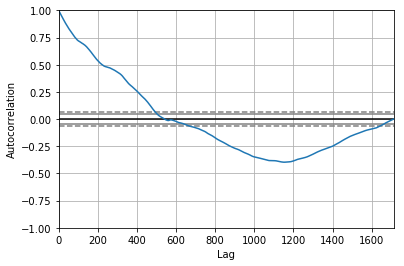

In [30]:
series = Series.from_csv('usdinr_dataset.csv',header=0)
autocorrelation_plot(series)
pyplot.show()

In [31]:
dataset.shape

(1712, 4)

## Step 1.2.1. Check for correlation

Good to have both positively and negatively correlated assets in the training set

In [32]:
corr = dataset.corr()
print(corr)

             USD/INR  BSE Sensex  Gold Price
USD/INR     1.000000    0.755530   -0.856715
BSE Sensex  0.755530    1.000000   -0.721223
Gold Price -0.856715   -0.721223    1.000000


In [33]:
def diagonal_correlation_matrix():
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = pyplot.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

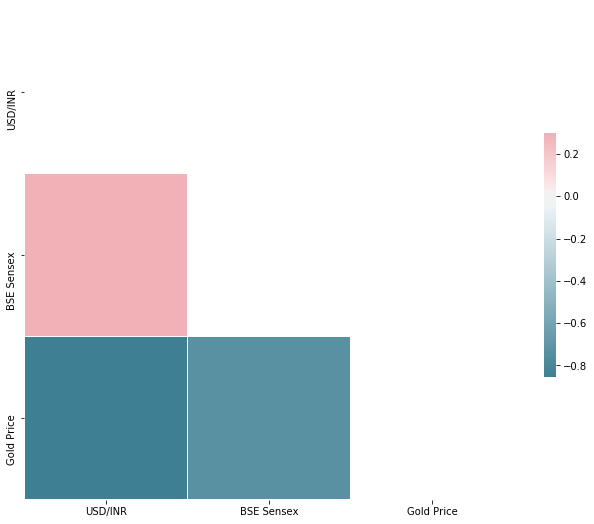

In [34]:
diagonal_correlation_matrix()

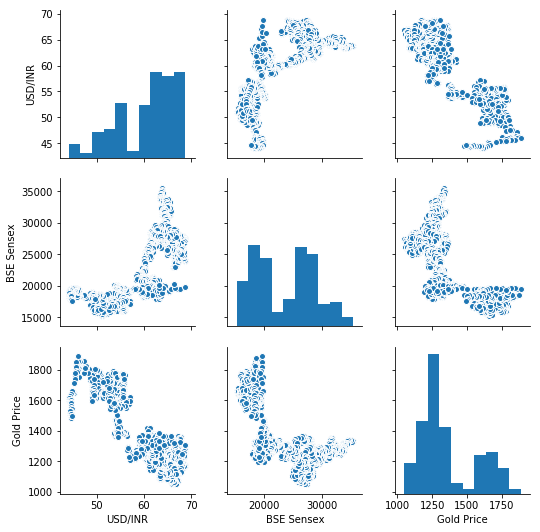

In [35]:

sns.pairplot(dataset)

## Step 1.3 -  Plot a graph to show the trend in the exchange rates

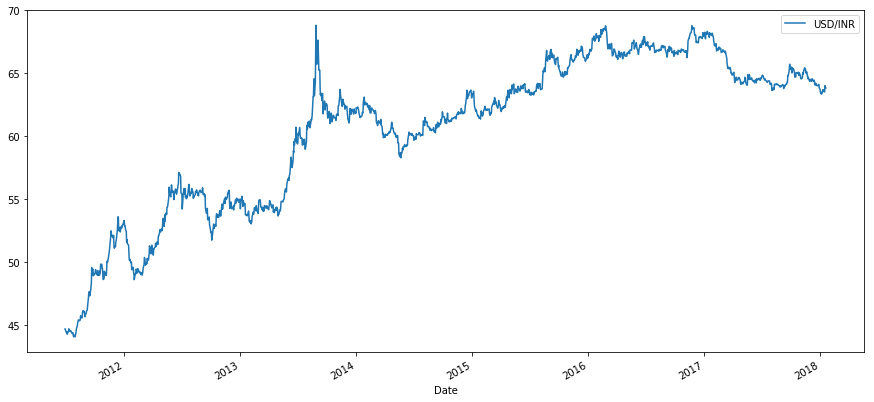

In [36]:
dataset.plot(y='USD/INR',x='Date', figsize=(15, 7))
pyplot.show()

## Step 1.4 Converting time series data to supervised learning data

In [40]:
# Credit https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [42]:
dataset = read_csv('usdinr_dataset.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# turn data to supervised
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5]],axis=1,inplace=True)

In [14]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.798707   1.000000   0.336914  0.800323
2   0.800323   0.987643   0.329872  0.801132
3   0.801132   0.978868   0.344194  0.806386
4   0.806386   0.963586   0.341687  0.786176
5   0.786176   0.967149   0.347297  0.789814


In [15]:
values = reframed.values
n_test = 277
train = values[n_test:,:]
test = values[:n_test,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1434, 1, 3) (1434,) (277, 1, 3) (277,)


In [21]:
model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2]),kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse'])

In [22]:
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1434 samples, validate on 277 samples
Epoch 1/100
 - 1s - loss: 1.8589 - mean_squared_error: 0.3636 - val_loss: 1.5239 - val_mean_squared_error: 0.3319
Epoch 2/100
 - 0s - loss: 1.0811 - mean_squared_error: 0.1734 - val_loss: 0.8290 - val_mean_squared_error: 0.1262
Epoch 3/100
 - 0s - loss: 0.5806 - mean_squared_error: 0.0715 - val_loss: 0.4018 - val_mean_squared_error: 0.0354
Epoch 4/100
 - 0s - loss: 0.3575 - mean_squared_error: 0.0417 - val_loss: 0.2468 - val_mean_squared_error: 0.0104
Epoch 5/100
 - 0s - loss: 0.2773 - mean_squared_error: 0.0318 - val_loss: 0.2503 - val_mean_squared_error: 0.0200
Epoch 6/100
 - 0s - loss: 0.2670 - mean_squared_error: 0.0366 - val_loss: 0.2342 - val_mean_squared_error: 0.0199
Epoch 7/100
 - 0s - loss: 0.2565 - mean_squared_error: 0.0385 - val_loss: 0.2252 - val_mean_squared_error: 0.0199
Epoch 8/100
 - 0s - loss: 0.2514 - mean_squared_error: 0.0395 - val_loss: 0.2198 - val_mean_squared_error: 0.0197
Epoch 9/100
 - 0s - loss: 0.2470 - mean_s

Epoch 72/100
 - 0s - loss: 0.1089 - mean_squared_error: 0.0011 - val_loss: 0.1303 - val_mean_squared_error: 0.0024
Epoch 73/100
 - 0s - loss: 0.1078 - mean_squared_error: 0.0010 - val_loss: 0.1278 - val_mean_squared_error: 0.0022
Epoch 74/100
 - 0s - loss: 0.1061 - mean_squared_error: 9.5444e-04 - val_loss: 0.1242 - val_mean_squared_error: 0.0019
Epoch 75/100
 - 0s - loss: 0.1045 - mean_squared_error: 8.5523e-04 - val_loss: 0.1206 - val_mean_squared_error: 0.0017
Epoch 76/100
 - 0s - loss: 0.1030 - mean_squared_error: 7.7102e-04 - val_loss: 0.1190 - val_mean_squared_error: 0.0016
Epoch 77/100
 - 0s - loss: 0.1016 - mean_squared_error: 7.2632e-04 - val_loss: 0.1204 - val_mean_squared_error: 0.0018
Epoch 78/100
 - 0s - loss: 0.1007 - mean_squared_error: 7.3082e-04 - val_loss: 0.1177 - val_mean_squared_error: 0.0016
Epoch 79/100
 - 0s - loss: 0.0993 - mean_squared_error: 6.7246e-04 - val_loss: 0.1144 - val_mean_squared_error: 0.0014
Epoch 80/100
 - 0s - loss: 0.0982 - mean_squared_error: 

In [23]:
def get_y_hat(test_X, test_y):
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    
    inv_yhat = inv_yhat.reshape((277,1))
    inv_y = inv_y.reshape((277,1))
    
    inv_yhat = pd.DataFrame(inv_yhat)
    inv_y = pd.DataFrame(inv_y)
    inv_yhat += 0.15
    
    return inv_yhat, inv_y

Test RMSE: 0.277


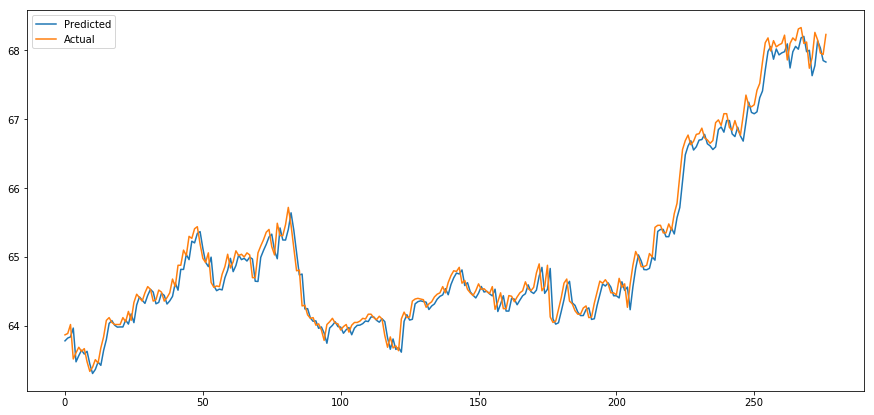

In [24]:
inv_yhat, inv_y = get_y_hat(test_X, test_y)
pyplot.figure(figsize=(15,7))
pyplot.plot(inv_yhat,label='Predicted')
pyplot.plot(inv_y,label='Actual')
pyplot.legend()

In [25]:
errr = inv_y-inv_yhat

In [ ]:
errr.plot(figsize=(15, 5))
pyplot.show()

In [ ]:
errr.describe()

# Part 2. Feature engineering with XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
CNHI = {"stock_name":"Google Inc", "data": pd.read_csv("Google_Stock_Price_Train.csv")}

In [ ]:
CNHI['data'].head()

In [ ]:
Predictors = pd.DataFrame({"sma2":CNHI["data"].Open.rolling(window=2).mean()})

In [ ]:
Predictors["sma2_1"] = Predictors.sma2.shift(1)

In [ ]:
Predictors.head(n=10)

In [ ]:
Predictors["sma2_increment"] = Predictors.sma2.diff()

In [ ]:
Predictors["sma2_1_increment"] = Predictors.sma2_1.diff()  

In [ ]:
Predictors["sma2_increment"] = Predictors.sma2.diff()  
 
Predictors["sma2_1_increment"] = Predictors.sma2_1.diff()  
 
Predictors["vol_increment"] = CNHI["data"].Volume.diff()
 
Predictors["vol_rel_increment"] = CNHI["data"].Volume.diff() / CNHI["data"].Volume
 
Predictors["open_1"] = CNHI["data"].Open.shift(1)
 
Predictors["open_incr"] = CNHI["data"].Open - CNHI["data"].Open.shift(1)
 
Predictors["open"] = CNHI["data"].Open
 

Predictors = Predictors.dropna()

In [ ]:
Predictors.head()

In [ ]:
target = pd.DataFrame({"value":Predictors.sma2.shift(-1) - Predictors.sma2}).dropna()

In [ ]:
X = pd.merge(Predictors, target,left_index=True,right_index=True)[Predictors.columns]
y = pd.merge(Predictors, target,left_index=True,right_index=True)[target.columns]
print(X.head())

In [ ]:
train_samples = int(X.shape[0] * 0.65)
 
X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]
 
y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

In [ ]:
def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
 

y_test_binary = pd.DataFrame(y_test["value"].apply(getBinary))

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.01)

In [ ]:
xgbModel = regressor.fit(X_train,y_train.value.apply(getBinary))
 
y_predicted = xgbModel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted] # (y_predicted > 0.5)
 
print ('Model accuracy = %.3f' % accuracy_score(y_test_binary,y_predicted_binary))

In [ ]:
fig = pyplot.figure(figsize=(8,8))
pyplot.xticks(rotation='vertical')
pyplot.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
pyplot.show()

# Part 3 - Other ways to predict prices

1. CNN
2. Trend - using simple NN or LR to predict whether the trend will be up or down
3. RL - algo that trains itself how to trade
4. NLP - for fundamental analysis